In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
sns.set(style="whitegrid")
df = pd.read_csv('tmdb_5000_movies.csv')
print(f"Original shape: {df.shape}")

Original shape: (4803, 20)


In [5]:
df_clean = df[(df['budget'] > 1000) & (df['revenue'] > 1000)].copy()
df_clean.dropna(subset=['runtime', 'vote_count', 'popularity'], inplace=True)
print(f"Shape after cleaning: {df_clean.shape}")

Shape after cleaning: (3211, 20)


In [6]:
df_clean['log_budget'] = np.log1p(df_clean['budget'])
df_clean['log_revenue'] = np.log1p(df_clean['revenue'])
df_clean['log_vote_count'] = np.log1p(df_clean['vote_count'])
df_clean['log_popularity'] = np.log1p(df_clean['popularity'])
df_clean['roi'] = (df_clean['revenue'] - df_clean['budget']) / df_clean['budget']
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(subset=['roi'], inplace=True)
def parse_genres(x):
    try:
        if isinstance(x, str):
            data = json.loads(x)
            return [d['name'] for d in data]
    except:
        return []
    return []
df_clean['genres_list'] = df_clean['genres'].apply(parse_genres)
all_genres = [g for sublist in df_clean['genres_list'] for g in sublist]
top_genres = pd.Series(all_genres).value_counts().head(10).index.tolist()
print(f"Top 10 Genres used for clustering: {top_genres}")
for genre in top_genres:
    df_clean[f'genre_{genre}'] = df_clean['genres_list'].apply(lambda x: 1 if genre in x else 0)
print("Feature Engineering Complete.")

Top 10 Genres used for clustering: ['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance', 'Crime', 'Science Fiction', 'Family', 'Fantasy']
Feature Engineering Complete.


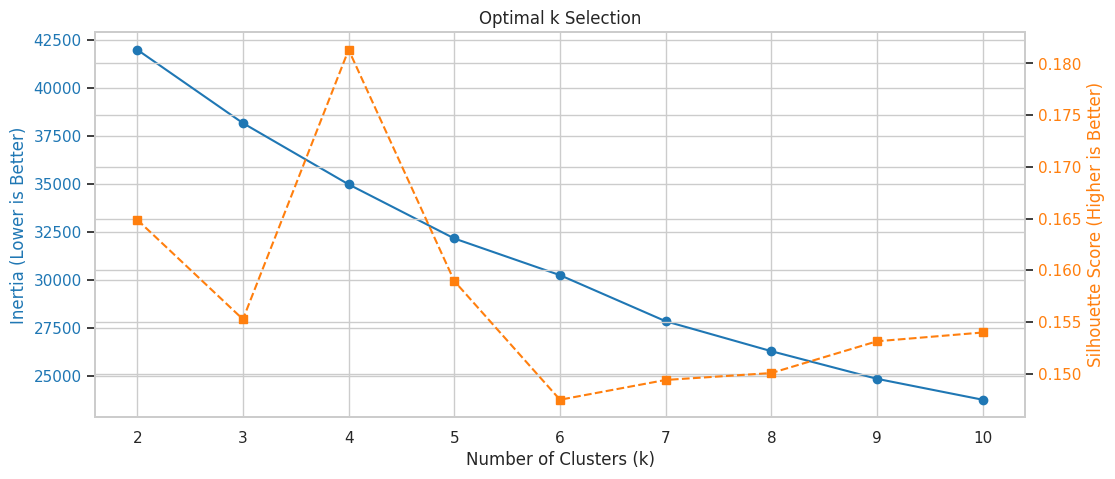

In [7]:
numeric_features = ['log_budget', 'log_revenue', 'vote_average', 'log_popularity', 'roi']
genre_features = [f'genre_{g}' for g in top_genres]
selected_features = numeric_features + genre_features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[selected_features])
inertia = []
silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Lower is Better)', color='tab:blue')
ax1.plot(K_range, inertia, 'o-', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score (Higher is Better)', color='tab:orange')
ax2.plot(K_range, silhouette_scores, 's--', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
plt.title('Optimal k Selection')
plt.show()

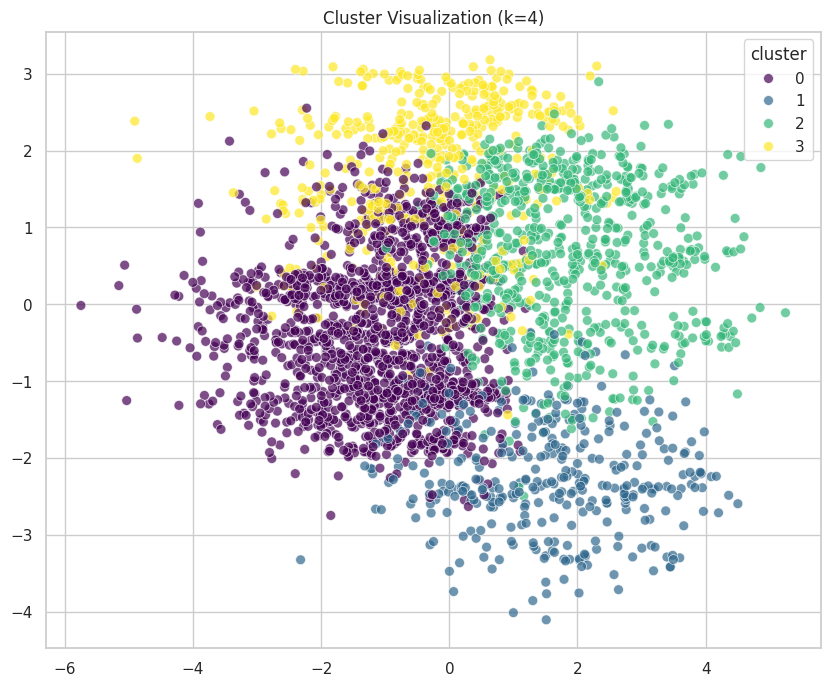

In [8]:
k_best = 4
kmeans = KMeans(n_clusters=k_best, random_state=42, n_init=10)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_clean['cluster'], palette='viridis', s=50, alpha=0.7)
plt.title(f'Cluster Visualization (k={k_best})')
plt.show()

In [9]:
summary_cols = ['budget', 'revenue', 'roi', 'vote_average', 'popularity']
cluster_summary = df_clean.groupby('cluster')[summary_cols].mean()
cluster_summary['count'] = df_clean['cluster'].value_counts()
print("Cluster Profiles (Financials):")
display(cluster_summary.style.background_gradient(cmap='coolwarm'))
genre_summary = df_clean.groupby('cluster')[genre_features].mean()
print("\nCluster Profiles (Genres - % of movies in cluster):")
display(genre_summary.style.background_gradient(cmap='Greens'))

Cluster Profiles (Financials):


,budget,revenue,roi,vote_average,popularity,count
cluster,,,,,,
0,22567325.969920,66171322.448742,17.016160,6.353346,20.396207,1629
1,69479499.107438,231631240.396694,4.226926,6.180165,37.567444,363
2,73099681.643855,220991318.912011,3.023158,6.171089,46.119448,716
3,33575740.216700,82244209.942346,2.275559,6.456262,27.333765,503



Cluster Profiles (Genres - % of movies in cluster):


,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Adventure,genre_Romance,genre_Crime,genre_Science Fiction,genre_Family,genre_Fantasy
cluster,,,,,,,,,,
0,0.585021,0.413137,0.165132,0.052793,0.034377,0.292818,0.002455,0.030694,0.003683,0.041743
1,0.154270,0.608815,0.008264,0.123967,0.473829,0.090909,0.005510,0.123967,0.980716,0.358127
2,0.209497,0.120112,0.487430,0.796089,0.554469,0.040503,0.013966,0.453911,0.001397,0.189944
3,0.538767,0.240557,0.614314,0.425447,0.069583,0.059642,1.000000,0.019881,0.001988,0.013917



--- ANALYZING GENRE: ACTION ---
Found 915 movies for Action.
Cluster Profiles for Action:


,budget,revenue,roi,popularity,count
genre_cluster,,,,,
0,87007318.431127,271397866.150268,2.583273,52.532260,559
1,24329677.267606,29590650.783099,1.902238,13.398752,355
2,400000.000000,100000000.000000,249.000000,33.142185,1


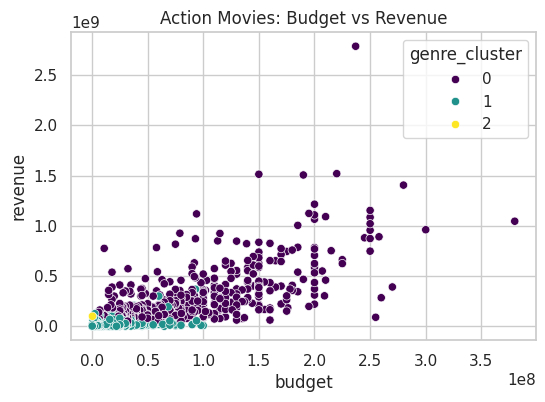


--- ANALYZING GENRE: THRILLER ---
Found 930 movies for Thriller.
Cluster Profiles for Thriller:


,budget,revenue,roi,popularity,count
genre_cluster,,,,,
0,15979415.528529,18868172.975976,2.754604,13.701003,333
1,232500.000000,66833091.000000,331.625039,24.275283,4
2,55578161.888702,162672934.613828,3.122887,40.475579,593


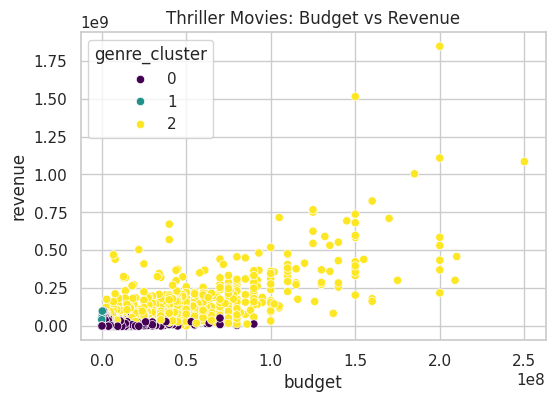


--- ANALYZING GENRE: DRAMA ---
Found 1430 movies for Drama.
Cluster Profiles for Drama:


,budget,revenue,roi,popularity,count
genre_cluster,,,,,
0,11224542.773619,12764042.461676,3.187675,9.541699,561
1,42706096.790751,127847513.150289,3.509522,34.811564,865
2,265750.000000,89422545.500000,466.962318,23.515979,4


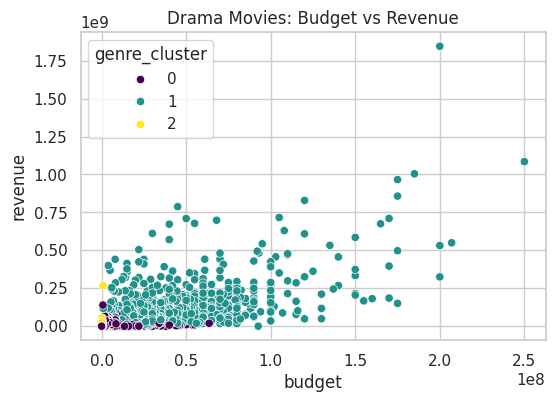


--- ANALYZING GENRE: COMEDY ---
Found 1101 movies for Comedy.
Cluster Profiles for Comedy:


,budget,revenue,roi,popularity,count
genre_cluster,,,,,
0,51290829.983607,165905237.371088,3.391397,34.524172,671
1,13274544.990632,21123197.119438,3.310176,9.418515,427
2,59000.000000,20525026.000000,402.205528,5.379380,3


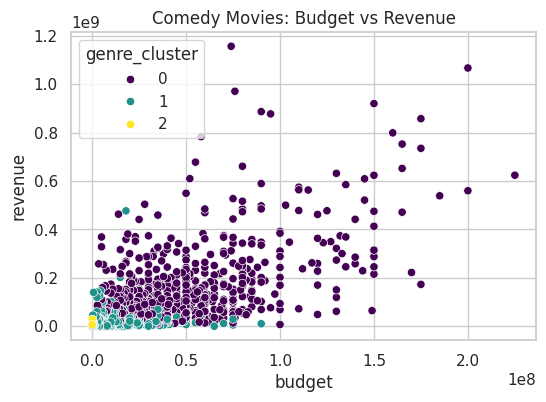

In [10]:
def analyze_genre_clusters(genre_name, k=3):
    print(f"\n--- ANALYZING GENRE: {genre_name.upper()} ---")

    genre_col = f'genre_{genre_name}'
    if genre_col not in df_clean.columns:
        print(f"Genre '{genre_name}' not found in top 10.")
        return

    df_genre = df_clean[df_clean[genre_col] == 1].copy()
    print(f"Found {len(df_genre)} movies for {genre_name}.")

    if len(df_genre) < 50:
        print("Not enough data to cluster.")
        return

    features = ['log_budget', 'log_revenue', 'roi', 'log_popularity']
    scaler_genre = StandardScaler()
    X_genre = scaler_genre.fit_transform(df_genre[features])

    kmeans_genre = KMeans(n_clusters=k, random_state=42, n_init=10)
    df_genre['genre_cluster'] = kmeans_genre.fit_predict(X_genre)

    summary = df_genre.groupby('genre_cluster')[['budget', 'revenue', 'roi', 'popularity']].mean()
    summary['count'] = df_genre['genre_cluster'].value_counts()

    print(f"Cluster Profiles for {genre_name}:")
    display(summary.style.background_gradient(cmap='coolwarm'))

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df_genre, x='budget', y='revenue', hue='genre_cluster', palette='viridis')
    plt.title(f'{genre_name} Movies: Budget vs Revenue')
    plt.show()

target_genres = ['Action', 'Thriller', 'Drama', 'Comedy']
for g in target_genres:
    analyze_genre_clusters(g, k=3)